# Alex example

This uses the files you sent me. The approach is to simply cast them into the normal `GrowthResults` class and use that. We start with the rates, we could ignore those because they are not used by eFVA. But for the sake of completeness...

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
import seaborn as sns
import micom
from umap import UMAP
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import zscore,pearsonr,ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.stats import wilcoxon
from skbio.diversity import alpha,beta_diversity
from skbio.stats import composition, subsample_counts
from scipy.stats import pearsonr
from tqdm.auto import tqdm as progbar
sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')

In [1]:
import pickle
import micom as mm

rates = pickle.load(open("120524_cdiff_fmt_growth_fva_input.pkl", "rb"))
rates = rates.rename(columns={"compartments": "taxon", "sample": "sample_id"})
rates.head()


,taxon,growth_rate,abundance,sample_id,condition,tradeoff
0,Clostridioides,0.027610,1.000000,1924.Sadowsky.119,0.0-Phoc_0.0-Top3-Probiotic,0.8
1,community,0.027610,1.000000,1924.Sadowsky.119,0.0-Phoc_0.0-Top3-Probiotic,0.8
2,Acidaminococcus,0.072583,0.007926,1924.Sadowsky.10r,0.0-Phoc_0.0-Top3-Probiotic,0.8
3,Adlercreutzia,0.046416,0.002972,1924.Sadowsky.10r,0.0-Phoc_0.0-Top3-Probiotic,0.8
4,Alistipes,0.604507,0.038639,1924.Sadowsky.10r,0.0-Phoc_0.0-Top3-Probiotic,0.8


Now we do the fluxes. We have to melt them into long format.

In [49]:
fluxes = pickle.load(open("120524_cdiff_fmt_flux_fva_input.pkl", "rb"))
fluxes = (
    fluxes
    .reset_index(drop=True)
    .melt(id_vars=["sample", "compartment", "condition"], var_name="reaction", value_name="flux")
    .dropna()
    .rename(columns={"sample": "sample_id", "compartment": "taxon"})
)
fluxes = fluxes[
    fluxes.reaction.str.startswith("EX_") &
    ~fluxes.reaction.str.contains("biomass") &
    (fluxes.flux.abs() > 0)]
fluxes["direction"] = fluxes.flux.apply(lambda x: "export" if x > 0 else "import")
fluxes.head()


,sample_id,taxon,condition,reaction,flux,direction
1649292,1924.Sadowsky.119,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,EX_12dgr180(e),-1.185658e-04,import
1649297,1924.Sadowsky.10r,Anaerobutyricum,0.0-Phoc_0.0-Top3-Probiotic,EX_12dgr180(e),-5.605442e-07,import
1649298,1924.Sadowsky.10r,Anaerostipes,0.0-Phoc_0.0-Top3-Probiotic,EX_12dgr180(e),-2.460172e-07,import
1649302,1924.Sadowsky.10r,Blautia,0.0-Phoc_0.0-Top3-Probiotic,EX_12dgr180(e),-2.242310e-04,import
1649303,1924.Sadowsky.10r,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,EX_12dgr180(e),-2.702777e-06,import


Finally the annotations. For that we rebuild them from the model database.

In [3]:
from micom.workflows.db_media import db_annotations

anns = db_annotations("../../arivale/agora103_genus.qza", threads=8)
anns.head()


Output()

[16:22:05] WARNING  The following sinks or demands were forced in the ]8;id=657718;file:///users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/micom/util.py\util.py]8;;\:]8;id=763176;file:///users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/micom/util.py#64\64]8;;\
                    model and have been relaxed since they would                
                    interfere with MICOM's growth rate estimation:              
                    DM_thmpp(c)                                                 


,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,reaction,chebi
0,2ddglcn[e],2-Dehydro-3-deoxy-D-gluconate,177.132060,6,0,NaN,NaN,NaN,NaN,EX_2ddglcn(e),NaN
1,ac[e],acetate,59.044020,2,0,HMDB00042,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",C00033,176,EX_ac(e),NaN
2,adocbl[e],Adenosylcobalamin,1579.581761,72,18,HMDB02086,NaN,C00194,NaN,EX_adocbl(e),NaN
3,akg[e],2-Oxoglutarate,144.082260,5,0,HMDB00208,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(...",C00026,51,EX_akg(e),NaN
4,ala_L[e],L-alanine,89.093180,3,1,HMDB00161,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00041,5950,EX_ala_L(e),NaN


Finally we assemble everything into `GrowthResults`.

In [4]:
from micom.workflows.results import GrowthResults

results = GrowthResults(rates, fluxes, anns)
results.save("120524_cdiff_fmt_results.pkl")

# Run the eFVA

Now we can run the eFVA using the fluxes you obtained. If your sample IDs are not unique (various conditions for the same sample) you would also have to make them unique first, for instance by appending the condition.

In [5]:
from fva import eFVA

efva_results = eFVA(
    results=results,
    model_db="../../arivale/agora103_genus.qza",
    taxa=["Clostridioides"],
    fva_threshold=0.99,
    threads=10
)

Output()

/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/cobra/util/so

In [7]:
efva_results[efva_results.metabolite == "succ[e]"]

,minimum,maximum,reaction,sample_id,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi
353,0.000000e+00,0.591700,EX_succ(e),1924.Sadowsky.119,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
725,-1.436410e-03,1.139273,EX_succ(e),1924.Sadowsky.112,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
1097,-1.167706e-01,0.095347,EX_succ(e),1924.Sadowsky.110,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
1469,-1.145454e-05,0.143879,EX_succ(e),1924.Sadowsky.102,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
1841,-3.267910e-01,0.326660,EX_succ(e),1924.Sadowsky.101,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49457,-1.365936e-01,0.102461,EX_succ(e),1924.Sadowsky.96,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
49829,-1.336939e-03,0.198040,EX_succ(e),1924.Sadowsky.9r,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
50201,-1.993482e-10,0.225608,EX_succ(e),1924.Sadowsky.97,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN
50573,-4.979237e-03,0.081183,EX_succ(e),1924.Sadowsky.98,succ[e],Succinate,116.07216,4,0,HMDB00254,"InChI=1S/C4H6O4/c5-3(6)1-2-4(7)8/h1-2H2,(H,5,6...",C00042,1110,NaN


In [ ]:
#Compute poor mans cv range (max-min)/(orginal value), plot value across sample and metabolites as a heatmap

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75b47cac69a0>>
Traceback (most recent call last):
  File "/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


<Axes: xlabel='maximum', ylabel='Count'>

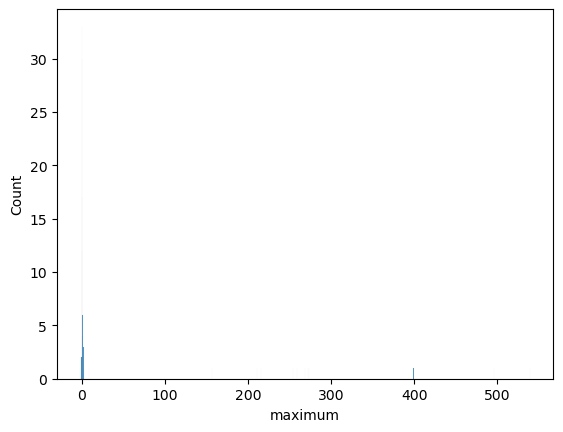

In [19]:
import seaborn as sns
import numpy as np
sns.histplot(efva_results[efva_results.metabolite == "succ[e]"].maximum)

/tmp/ipykernel_2994216/4237326768.py:4: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(efva_results[efva_results.metabolite == "succ[e]"].maximum.values))


(array([ 3.,  3.,  6.,  4.,  3.,  2., 11., 64.,  5., 11.]),
 array([-9.86284267, -8.6033343 , -7.34382594, -6.08431758, -4.82480922,
        -3.56530086, -2.3057925 , -1.04628414,  0.21322423,  1.47273259,
         2.73224095]),
 <BarContainer object of 10 artists>)

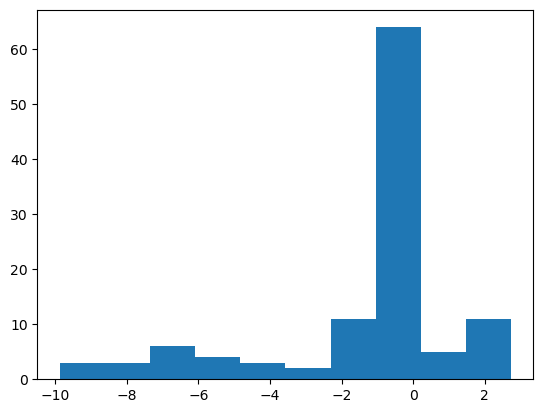

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.log10(efva_results[efva_results.metabolite == "succ[e]"].maximum.values))

In [169]:
import pandas as pd
merged=pd.merge(efva_results,fluxes[fluxes.taxon=='Clostridioides'],on=['sample_id','reaction'])
for col in ['minimum','maximum','flux']:
    idx=merged[(merged[col]<0)&(abs(merged[col])<10**-6)].index
    merged.loc[idx,col]=-10**-6
    
    idx=merged[(merged[col]>0)&(merged[col]<10**-6)].index
    merged.loc[idx,col]=10**-6

merged['cv']=(merged['maximum']-merged['minimum'])/(merged['flux'])
idx=merged[merged.cv!=0].index
merged.loc[idx,'log_cv']=np.log10(abs(merged.loc[idx,'cv']))
merged

,minimum,maximum,reaction,sample_id,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,taxon,condition,flux,direction,cv,log_cv
0,-0.000119,0.000000,EX_12dgr180(e),1924.Sadowsky.119,12dgr180[e],"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",625.01774,39,0,NaN,NaN,NaN,NaN,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000119,import,-1.000000,0.000000
1,0.000000,0.265314,EX_2mbut(e),1924.Sadowsky.119,2mbut[e],2-methylbutyrate,101.12376,5,0,NaN,NaN,C18319,NaN,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,265313.972238,5.423760
2,0.000000,0.000000,EX_4abut(e),1924.Sadowsky.119,4abut[e],4-Aminobutanoate,103.11976,4,1,HMDB00112,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C00334,119,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,0.000000,NaN
3,0.000000,0.158599,EX_4hphac(e),1924.Sadowsky.119,4hphac[e],4-hydroxyphenylacetate,151.13938,8,0,HMDB00020,InChI=1S/C8H8O3/c9-7-3-1-6(2-4-7)5-8(10)11/h1-...,C00642,127,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,158599.150767,5.200301
4,0.000000,0.207375,EX_5aptn(e),1924.Sadowsky.119,5aptn[e],5-Aminopentanoate,117.14634,5,1,NaN,"InChI=1S/C5H11NO2/c6-4-2-1-3-5(7)8/h1-4,6H2,(H...",NaN,3720,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,207374.506496,5.316755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42954,0.000000,0.585916,EX_urea(e),1924.Sadowsky.99,urea[e],Urea,60.05526,1,2,HMDB00294,"InChI=1S/CH4N2O/c2-1(3)4/h(H4,2,3,4)",C00086,1176,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,585916.168493,5.767835
42955,-0.000001,-0.000001,EX_val_L(e),1924.Sadowsky.99,val_L[e],L-valine,117.14634,5,1,HMDB00883,"InChI=1S/C5H11NO2/c1-3(2)4(6)5(7)8/h3-4H,6H2,1...",C00183,6287,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-0.000000,NaN
42956,-0.000001,0.000000,EX_xan(e),1924.Sadowsky.99,xan[e],Xanthine,152.11086,5,4,HMDB00292,InChI=1S/C5H4N4O2/c10-4-2-3(7-1-6-2)8-5(11)9-4...,C00385,1188,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-1.000000,0.000000
42957,-0.000001,0.000000,EX_xyl_D(e),1924.Sadowsky.99,xyl_D[e],aldehydo-D-xylose,150.12990,5,0,NaN,"InChI=1S/C5H10O5/c6-1-3(8)5(10)4(9)2-7/h1,3-5,...",NaN,644160,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-1.000000,0.000000


In [83]:

flux_table=fluxes.pivot(index=['sample_id','taxon'],columns='reaction',values='flux').fillna(10**-6)
exchanges=flux_table[flux_table.columns[['EX_' in x for x in flux_table.columns ]]]
export_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
export_flux[export_flux<=0]=10**-6
export_flux=np.log10(export_flux)
export_flux[export_flux<-6]=-6
export_flux

import_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
import_flux[import_flux >=0]=10**-6
import_flux=abs(import_flux)
import_flux=np.log10(import_flux)
import_flux=import_flux[import_flux>-6].fillna(-6)
import_flux

imprts=import_flux.reset_index()
imprts=imprts[imprts.taxon=='Clostridioides']
cdiff_rate=rates[rates.taxon=='Clostridioides']
cdiff_import=pd.merge(imprts,cdiff_rate,left_on='sample_id',right_on='sample_id')
cdiff_import=cdiff_import.drop(['taxon_x','taxon_y'],axis=1)
cdiff_import['log_growth']=np.log10(cdiff_import.growth_rate)
cdiff_import

,sample_id,EX_12dgr180(e),EX_12dgr180_m,EX_12dhchol(e),EX_12dhchol_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13ppd(e),EX_13ppd_m,EX_15dap(e),...,EX_xylan_m,EX_xyluglc(e),EX_xyluglc_m,EX_zn2(e),EX_zn2_m,growth_rate,abundance,condition,tradeoff,log_growth
0,1924.Sadowsky.10,-2.270756,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-2.695507,-6.0,2.560159e-01,0.100317,0.0-Phoc_0.0-Top3-Probiotic,0.8,-0.591733
1,1924.Sadowsky.100,-5.175445,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-5.857874,-6.0,1.796709e-04,0.100629,0.0-Phoc_0.0-Top3-Probiotic,0.8,-3.745522
2,1924.Sadowsky.101,-3.911527,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-4.118719,-6.0,9.662299e-03,0.101031,0.0-Phoc_0.0-Top3-Probiotic,0.8,-2.014920
3,1924.Sadowsky.102,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.000000,-6.0,1.887758e-06,0.100532,0.0-Phoc_0.0-Top3-Probiotic,0.8,-5.724054
4,1924.Sadowsky.103,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.000000,-6.0,1.131455e-08,0.100767,0.0-Phoc_0.0-Top3-Probiotic,0.8,-7.946363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1924.Sadowsky.96,-4.658122,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.000000,-6.0,5.586903e-06,0.100420,0.0-Phoc_0.0-Top3-Probiotic,0.8,-5.252829
133,1924.Sadowsky.97,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.000000,-6.0,2.295457e-12,0.100401,0.0-Phoc_0.0-Top3-Probiotic,0.8,-11.639131
134,1924.Sadowsky.98,-4.852025,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-4.547046,-6.0,3.604509e-03,0.100295,0.0-Phoc_0.0-Top3-Probiotic,0.8,-2.443154
135,1924.Sadowsky.99,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.000000,-6.0,1.153173e-08,0.100509,0.0-Phoc_0.0-Top3-Probiotic,0.8,-7.938106


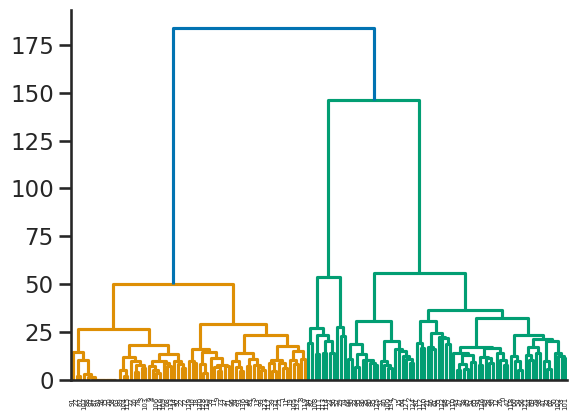

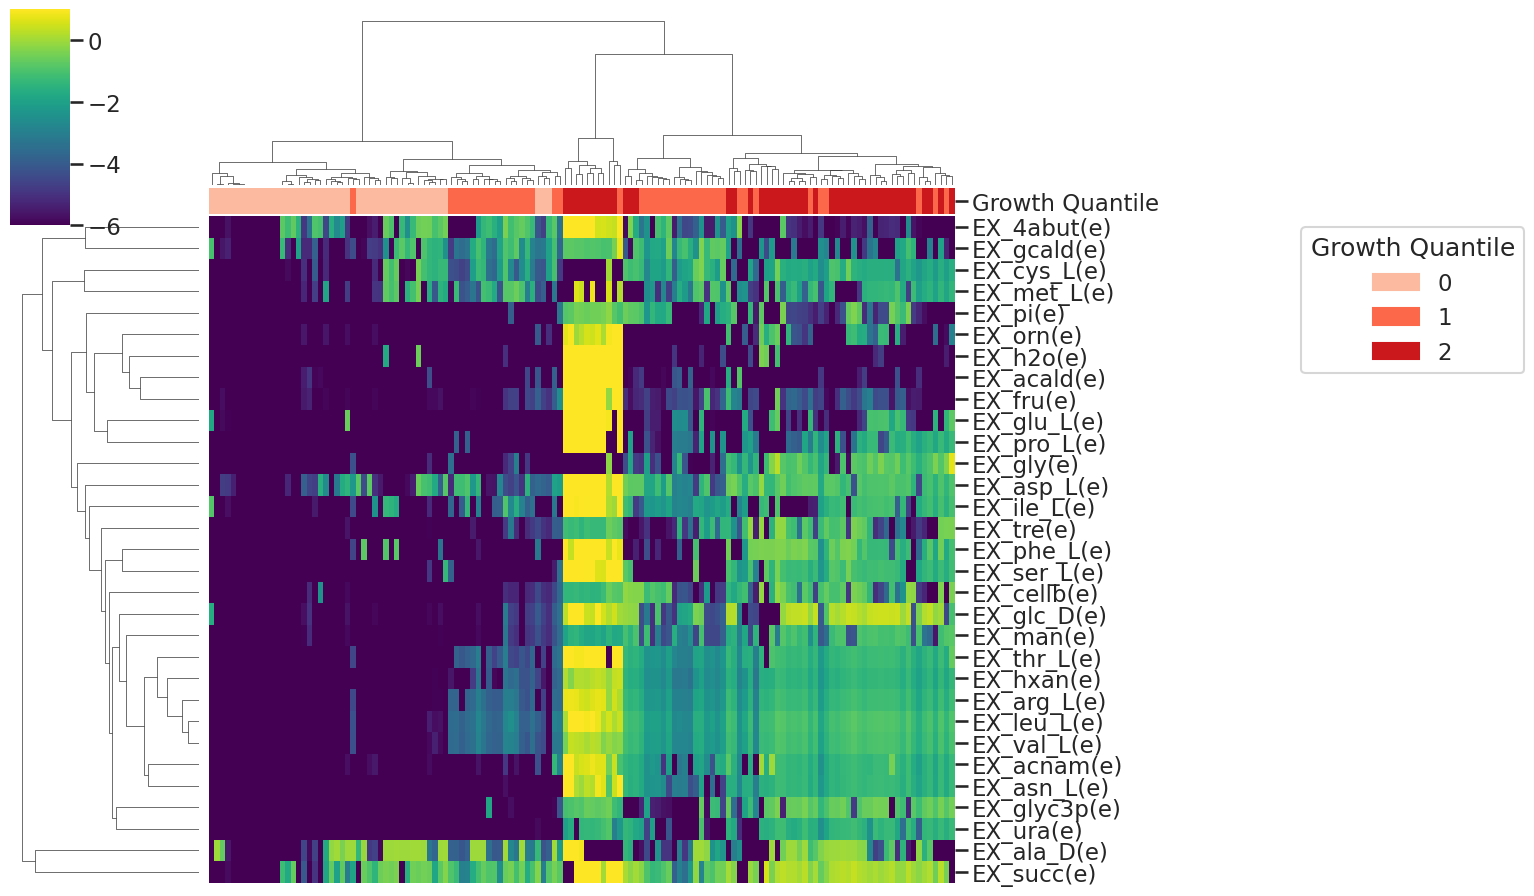

In [221]:

df=cdiff_import.copy()

max_d =150
X=df.iloc[:,1:-5]
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
colors=sns.color_palette('colorblind',len(pd.unique(clusters)))
cmap={i:colors[i-1] for i in pd.unique(clusters)}
n=3
df['Growth Quantile']=pd.qcut(df.log_growth,n,labels=False)
df.index=df['sample_id']
colors=sns.color_palette('Reds',n)
cmap = {}
i = 0
for group in sorted(df['Growth Quantile'].unique()):
    cmap[group] = colors[i]
    i+=1
#Use color dictionary to map color to speces column (provides color of each data point)
col_colors=df['Growth Quantile'].copy()
col_colors=col_colors.map(cmap)
idx=['EX_4abut(e)', 'EX_acald(e)', 'EX_acnam(e)', 'EX_ala_D(e)',
       'EX_arg_L(e)', 'EX_asn_L(e)', 'EX_asp_L(e)', 'EX_cellb(e)',
       'EX_cys_L(e)', 'EX_fru(e)', 'EX_gcald(e)', 'EX_glc_D(e)', 'EX_glu_L(e)',
       'EX_gly(e)', 'EX_glyc3p(e)', 'EX_h2o(e)', 'EX_hxan(e)', 'EX_ile_L(e)',
       'EX_leu_L(e)', 'EX_man(e)', 'EX_met_L(e)', 'EX_orn(e)', 'EX_phe_L(e)',
       'EX_pi(e)', 'EX_pro_L(e)', 'EX_ser_L(e)', 'EX_succ(e)', 'EX_thr_L(e)',
       'EX_tre(e)', 'EX_ura(e)', 'EX_val_L(e)']
hits=idx
clust=sns.clustermap(df.iloc[:,1:-5][idx].T,cmap='viridis',vmin=-6,vmax=1,figsize=(12,12),col_linkage=Z,col_colors=col_colors,yticklabels=1)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])
#Create custom legend to include in plot 
handles = []
labels = sorted(df['Growth Quantile'].unique())
for i in range(len(sorted(labels))):
    patch = mpatches.Patch(color=colors[i],label=labels[i])
    handles.append(patch)  
clust.ax_heatmap.legend(handles=handles,bbox_to_anchor=(1.45,1),loc=2,title='Growth Quantile')
order=clust.data2d.columns

<Axes: xlabel='Growth Quantile', ylabel='log_growth'>

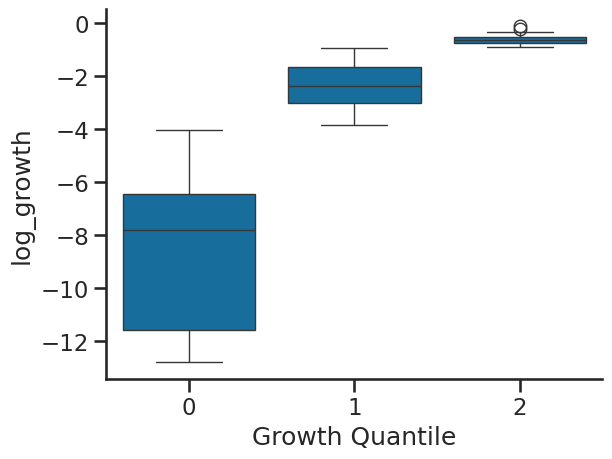

In [223]:
sns.boxplot(x='Growth Quantile',y='log_growth',data=df)

[]

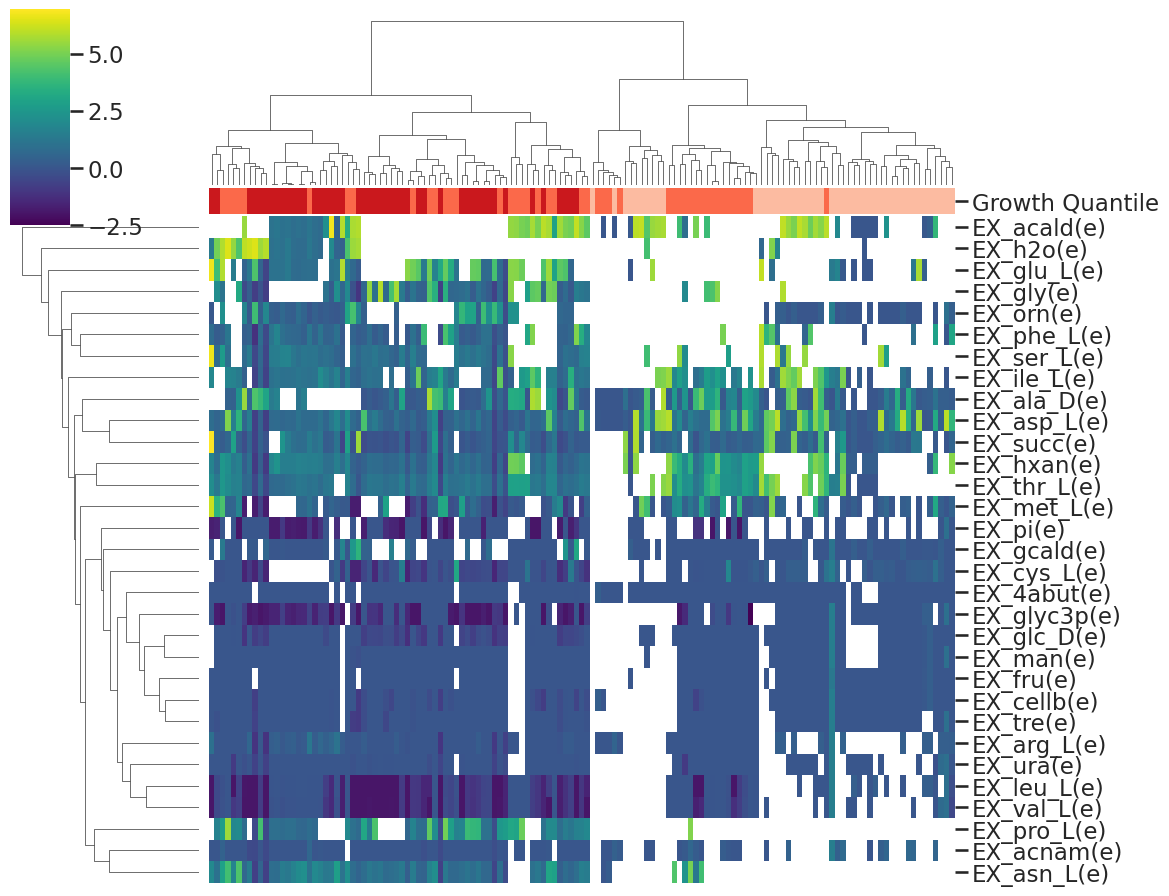

In [183]:
log_cv=merged[(merged.direction=='import')&(merged.reaction.isin(hits))].pivot(index='sample_id',columns='reaction',values='log_cv')
mask_nan = log_cv.isnull().T
log_cv=log_cv.fillna(-6)
Z = linkage(log_cv, 'ward')
clust=sns.clustermap(log_cv.T,cmap='viridis',figsize=(12,12),col_colors=col_colors,yticklabels=1,col_linkage=Z,mask=mask_nan)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])
#plt.savefig('FVA-logCV-heatmap-v3.pdf',bbox_inches='tight')

(array([31., 62., 14.,  2.,  5.,  0.,  2.,  3.,  2.,  1.]),
 array([-0.66489564,  0.09655672,  0.85800908,  1.61946144,  2.3809138 ,
         3.14236616,  3.90381853,  4.66527089,  5.42672325,  6.18817561,
         6.94962797]),
 <BarContainer object of 10 artists>)

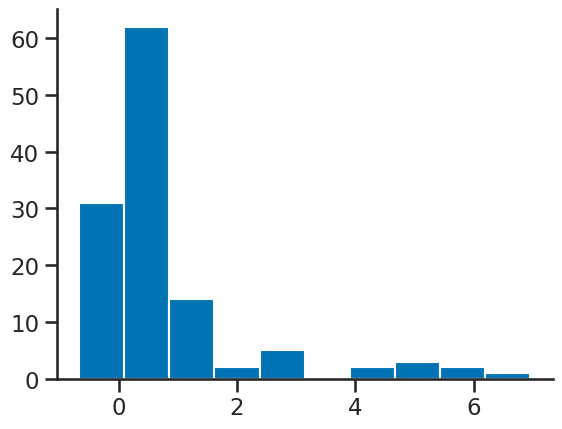

In [125]:
x=log_cv['EX_succ(e)'].values
x=x[x>-6]
plt.hist(x)

In [193]:
merged

,minimum,maximum,reaction,sample_id,metabolite,name,molecular_weight,C_number,N_number,hmdb,...,chebi,taxon,condition,flux,direction,cv,log_cv,growth_quantile,log_max,log_min
0,-0.000119,0.000000,EX_12dgr180(e),1924.Sadowsky.119,12dgr180[e],"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",625.01774,39,0,NaN,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000119,import,-1.000000,0.000000,1,-inf,-3.926041
1,0.000000,0.265314,EX_2mbut(e),1924.Sadowsky.119,2mbut[e],2-methylbutyrate,101.12376,5,0,NaN,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,265313.972238,5.423760,1,-0.576240,-inf
2,0.000000,0.000000,EX_4abut(e),1924.Sadowsky.119,4abut[e],4-Aminobutanoate,103.11976,4,1,HMDB00112,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,0.000000,NaN,1,-inf,-inf
3,0.000000,0.158599,EX_4hphac(e),1924.Sadowsky.119,4hphac[e],4-hydroxyphenylacetate,151.13938,8,0,HMDB00020,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,158599.150767,5.200301,1,-0.799699,-inf
4,0.000000,0.207375,EX_5aptn(e),1924.Sadowsky.119,5aptn[e],5-Aminopentanoate,117.14634,5,1,NaN,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,207374.506496,5.316755,1,-0.683245,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42954,0.000000,0.585916,EX_urea(e),1924.Sadowsky.99,urea[e],Urea,60.05526,1,2,HMDB00294,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,0.000001,export,585916.168493,5.767835,0,-0.232165,-inf
42955,-0.000001,-0.000001,EX_val_L(e),1924.Sadowsky.99,val_L[e],L-valine,117.14634,5,1,HMDB00883,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-0.000000,NaN,0,-6.000000,-6.000000
42956,-0.000001,0.000000,EX_xan(e),1924.Sadowsky.99,xan[e],Xanthine,152.11086,5,4,HMDB00292,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-1.000000,0.000000,0,-inf,-6.000000
42957,-0.000001,0.000000,EX_xyl_D(e),1924.Sadowsky.99,xyl_D[e],aldehydo-D-xylose,150.12990,5,0,NaN,...,NaN,Clostridioides,0.0-Phoc_0.0-Top3-Probiotic,-0.000001,import,-1.000000,0.000000,0,-inf,-6.000000


/users/acarr/anaconda3/envs/micom/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


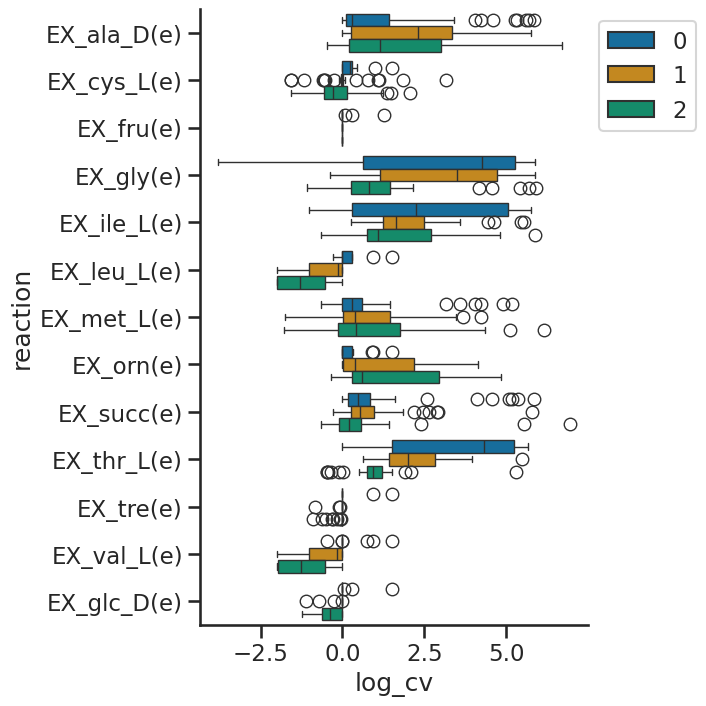

In [192]:
plt.figure(figsize=(5,8))
merged['growth_quantile']=merged.sample_id.map(df['Growth Quantile'].to_dict())
merged['log_max']=np.log10(abs(merged.maximum))
merged['log_min']=np.log10(abs(merged.minimum))

sns.boxplot(y='reaction',x='log_cv',hue='growth_quantile',data=merged[merged.reaction.isin(['EX_ala_D(e)',
 'EX_cys_L(e)',
 'EX_fru(e)',
 'EX_glc_D(e)',
 'EX_gly(e)',
 'EX_ile_L(e)',
 'EX_leu_L(e)',
 'EX_met_L(e)',
 'EX_orn(e)',
 'EX_succ(e)',
 'EX_thr_L(e)',
 'EX_tre(e)',
 'EX_val_L(e)'])],palette='colorblind')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('FVA-logcv-boxplot.pdf',bbox_inches='tight')

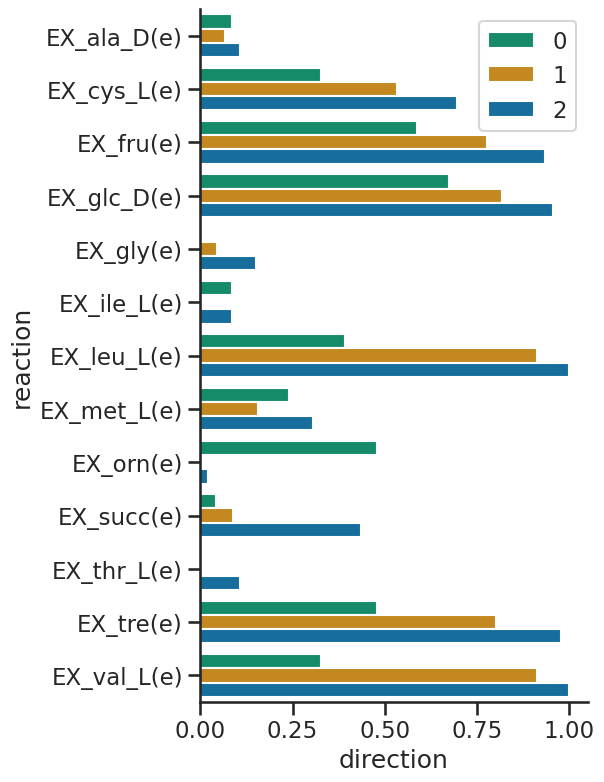

In [227]:
df=merged[merged.reaction.isin(['EX_ala_D(e)',
 'EX_cys_L(e)',
 'EX_fru(e)',
 'EX_glc_D(e)',
 'EX_gly(e)',
 'EX_ile_L(e)',
 'EX_leu_L(e)',
 'EX_met_L(e)',
 'EX_orn(e)',
 'EX_succ(e)',
 'EX_thr_L(e)',
 'EX_tre(e)',
 'EX_val_L(e)'])][['reaction','growth_quantile','maximum','minimum']]

def f(x):
    if x['maximum']<=10**-6 and x['minimum']<0:
        return 1
    else:
        return 0
df['direction']=df.apply(f,axis=1)
mean=df.groupby(by=['reaction','growth_quantile']).mean().reset_index()
plt.figure(figsize=(5,9))
colors=sns.color_palette('colorblind')
sns.barplot(y='reaction',x='direction',data=mean,hue='growth_quantile',palette=[colors[2],colors[1],colors[0]])
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('import-fracion-barplot.pdf',bbox_inches='tight')